<a href="https://colab.research.google.com/github/aitormorais/Qiskit/blob/main/qbit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 34.8 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

In [5]:
import qiskit

In [6]:
from qiskit_aer import AerSimulator

In [7]:
from qiskit import QuantumRegister, QuantumCircuit,Aer, execute,ClassicalRegister

In [3]:
def generar_grafo(numero_ciudades):
    """
    Genera un grafo completo con un número dado de ciudades como nodos y asigna distancias aleatorias a cada par de nodos comprendidas entre el 1 y el 10.
    
    Parámetros
    ----------
    numero_ciudades : int
        El número de ciudades (nodos) para incluir en el grafo.
        
    Devoluciones
    ------------
    G : networkx.classes.graph.Graph
        Un objeto de grafo completo de NetworkX con 'numero_ciudades' nodos y distancias aleatorias asignadas a cada par de nodos.
        
    distancias : dict
        Un diccionario de NetworkX que mapea cada par de nodos a la 'distancia' entre ellos. Las claves del diccionario son tuplas de dos elementos que representan los pares de nodos, y los valores son las distancias aleatorias asignadas.
        
    Ejemplo
    -------
    >>> G, distancias = generar_grafo(5)
    >>> print(G.edges(data=True))
    [(0, 1, {'distancia': 3}), (0, 2, {'distancia': 7}), (0, 3, {'distancia': 2}), (0, 4, {'distancia': 6}), 
    (1, 2, {'distancia': 10}), (1, 3, {'distancia': 1}), (1, 4, {'distancia': 8}), (2, 3, {'distancia': 4}), 
    (2, 4, {'distancia': 5}), (3, 4, {'distancia': 9})]
    >>> print(distancias)
    {(0, 1): 3, (0, 2): 7, (0, 3): 2, (0, 4): 6, (1, 2): 10, (1, 3): 1, (1, 4): 8, (2, 3): 4, (2, 4): 5, (3, 4): 9}
    """
    # Crear un grafo completo con 'numero_ciudades' nodos
    G = nx.complete_graph(numero_ciudades)
    # Asignar una distancia aleatoria (entre 1 y 10) a cada par de nodos
    for (u, v) in G.edges():
        G.edges[u, v]['distancia'] = 1
    # Obtener un diccionario de las distancias entre cada par de nodos
    distancias = nx.get_edge_attributes(G, 'peso')
    return G, distancias


In [8]:


def generate_hamiltonian_graph(num_nodes):
    # Crea un nuevo grafo no dirigido
    G = nx.Graph()

    # Agrega los nodos al grafo
    G.add_nodes_from(range(num_nodes))

    # Genera un camino Hamiltoniano
    for i in range(num_nodes - 1):
        G.add_edge(i, i + 1, weight=1.0)
    G.add_edge(num_nodes - 1, 0, weight=1.0)  # Cierra el ciclo para hacerlo Hamiltoniano

    # Agrega más aristas de manera aleatoria
    for i in range(num_nodes):
        for j in range(i + 2, num_nodes):
            if np.random.random() > 0.5:  # Añade la arista con una probabilidad del 50%
                G.add_edge(i, j, weight=1.0)

    return G


In [9]:
grafo = generate_hamiltonian_graph(6)

In [10]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "peso")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [11]:
colors = ["r" for node in grafo.nodes()]
pos = nx.spring_layout(grafo)

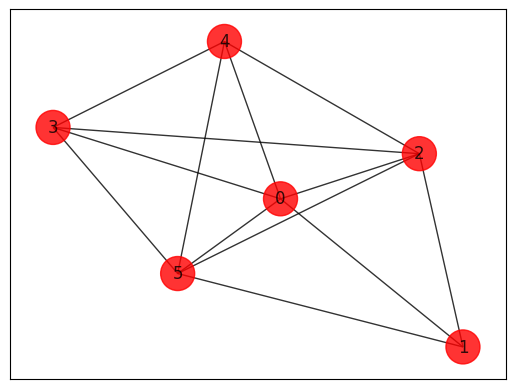

In [12]:
draw_graph(grafo, colors, pos)

In [13]:
G = grafo
n = 6

In [14]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 0. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]]


case = (0, 0, 0, 0, 0, 0) cost = 0.0
case = (1, 0, 0, 0, 0, 0) cost = 5.0
case = (0, 1, 0, 0, 0, 0) cost = 3.0
case = (1, 1, 0, 0, 0, 0) cost = 6.0
case = (0, 0, 1, 0, 0, 0) cost = 5.0
case = (1, 0, 1, 0, 0, 0) cost = 8.0
case = (0, 1, 1, 0, 0, 0) cost = 6.0
case = (1, 1, 1, 0, 0, 0) cost = 7.0
case = (0, 0, 0, 1, 0, 0) cost = 4.0
case = (1, 0, 0, 1, 0, 0) cost = 7.0
case = (0, 1, 0, 1, 0, 0) cost = 7.0
case = (1, 1, 0, 1, 0, 0) cost = 8.0
case = (0, 0, 1, 1, 0, 0) cost = 7.0
case = (1, 0, 1, 1, 0, 0) cost = 8.0
case = (0, 1, 1, 1, 0, 0) cost = 8.0
case = (1, 1, 1, 1, 0, 0) cost = 7.0
case = (0, 0, 0, 0, 1, 0) cost = 4.0
case = (1, 0, 0, 0, 1, 0) cost = 7.0
case = (0, 1, 0, 0, 1, 0) cost = 7.0
case = (1, 1, 0, 0, 1, 0) cost = 8.0
case = (0, 0, 1, 0, 1, 0) cost = 7.0
case = (1, 0, 1, 0, 1, 0) cost = 8.0
case = (0, 1, 1, 0, 1, 0) cost = 8.0
case = (1, 1, 1, 0, 1, 0) cost = 7.0
case = (0, 0, 0, 1, 1, 0) cost = 6.0
case = (1, 0, 0, 1, 1, 0) cost = 7.0
case = (0, 1, 0, 1, 1, 0) cost = 9.0
c

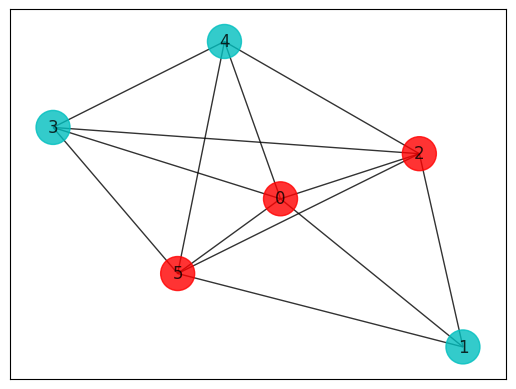

In [15]:
best_cost_brute = 0
cost_dict = {}  # Diccionario para almacenar los casos y sus costos

for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(tuple(x)) + " cost = " + str(cost))
    
    # Almacenar el caso y el costo en el diccionario
    cost_dict[tuple(x)] = cost

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

# Imprimir el diccionario de costos
for case, cost in cost_dict.items():
    print(f"Case: {case}, Cost: {cost}")


In [26]:
def string_to_tuple(s):
    return tuple(int(char) for char in s)


Qiskit


In [20]:
def get_random_number(qc,qubit,reg):

    qc.h(qubit[0])
    qc.measure(qubit[0],reg[0])
    
    with qc.if_test((reg, 1)):
        qc.x(qubit[0])

    backend_sim = AerSimulator()
    reset_sim_job = backend_sim.run(qc,shots = 1)
    reset_sim_result = reset_sim_job.result()
    counts = reset_sim_result.get_counts(qc)

    key = list(counts.keys())[0]
    first_digit = int(key[0])  # Convert the first character of the key to an integer
    return first_digit


In [47]:
def lanzar_circ_dinamico(qc,registro):
  # initialize the simulator
  backend_sim = AerSimulator()

  # run the circuit
  reset_sim_job = backend_sim.run(qc,backend_sim,shots = 1)
  # get the results
  reset_sim_result = reset_sim_job.result()
  # retrieve the bitstring counts
  counts = reset_sim_result.get_counts(qc)
  print(type(int(list(counts.keys())[0])))
  print(int(list(counts.keys())[0]))
  return int(list(counts.keys())[0])

In [ ]:
def mutate_bit_random(qr,qc,probabilidad):
  """mutar bit random"""
  #mutar un qbit aleatorio
  if np.random.random() > probabilidad:
    qc.x(qr[np.random.randint(0,len(qr))])
  


In [ ]:
def mutate_bit(qr,qc,bit):
  """dado un bit a mutar un qr y qc muta ese bit"""
  qc.x(qr[bit])

def mutate_multi_bit(qr,qc,probabilidad):#prob >0 and prob <1 a mas grande prob menos oportunidades de mutar
  for i in range(len(qr)):
     if np.random.random() > probabilidad:
      mutate_bit(qr,qc,i)

def mutate_bit_random(qr,qc,probabilidad):
  """mutar bit random"""
  #mutar un qbit aleatorio
  if np.random.random() > probabilidad:
    qc.x(qr[np.random.randint(0,len(qr))])

def mutate_exchange(qr,qc,probabilidad):
   if np.random.random() > probabilidad:
    numero0 = np.random.randint(0,len(qr))
    numero1  = np.random.randint(0,len(qr))
    if numero0 != numero1:
      qc.swap(qr[numero0], qr[numero1])





In [ ]:
def mutate_exchange(qr,qc,probabilidad):
   if np.random.random() > probabilidad:
    numero0 = np.random.randint(0,len(qr))
    numero1  = np.random.randint(0,len(qr))
    if numero0 != numero1:
      qc.swap(qr[numero0], qr[numero1])




In [18]:
def puntos(qr):
  numero = np.random.randint(1,len(qr)-1) 
  num = np.random.randint(1,len(qr)-1)
  while numero == num:
    num = np.random.randint(1,len(qr)-1)
  if num > numero:
    return numero,num
  else:
    return num,numero


In [29]:
def escribir(qc,qreg, bin_string):

    """funcion que sirve tanto para escribir como para 'resetear' un registro, si quieres escribir sin tener que poner tu manualmente las puertas not en bin_string pon el numero que quieras.
    Si por el contrario quieres resetear tu resultado de un registro cuantico bin_string tiene que ser el contenido actual del registro cuantico

    """
    # Creamos un QuantumCircuit usando el QuantumRegister
    #qc = QuantumCircuit(qreg)
    
    # Verificamos si el tamaño del QuantumRegister es suficiente para el string binario
    if qreg.size < len(bin_string):
        raise ValueError("El QuantumRegister no es suficientemente grande para el string binario")

    # Recuerda que Qiskit usa notación little-endian, por lo que necesitamos invertir el string
    bin_string = bin_string[::-1]
    
    # Aplicamos la puerta X (NOT) a los qubits correspondientes
    for i, bit in enumerate(bin_string):
      if bit == '1':
          qc.x(i)

In [6]:
def create_qc(number_quantum_reg,qubits,number_classic_reg,bits):
  """facilita el crear circuitos cuanticos si quieres poner ancillas aconesjo hacerlo manualmente partiendo desde aqui"""
  
  # Create quantum registers
  qregs = [QuantumRegister(qubits, name=f'q{i}') for i in range(number_quantum_reg)]
  ancilla = QuantumRegister(1, name='ancilla')

  # Create classical registers
  cregs = [ClassicalRegister(bits, name=f'c{i}') for i in range(number_classic_reg)]
  cr_ancilla = ClassicalRegister(1, name='cr_ancilla')

  # Create a quantum circuit
  return QuantumCircuit(*qregs, ancilla, *cregs, cr_ancilla)


In [24]:
def lanzar_dinamico(circuito):
  backend_sim = AerSimulator()

  # run the circuit
  reset_sim_job = backend_sim.run(circuito,shots = 1)
  # get the results
  reset_sim_result = reset_sim_job.result()
  # retrieve the bitstring counts
  return reset_sim_result.get_counts()


In [22]:
def valores_hijos(resultados):
  "suponiendo que solo tenemos dos creg"
  for key in resultados.keys():
    return string_to_tuple(key.split(' ')[2]),string_to_tuple(key.split(' ')[1])
    #hijo1 = key.split(' ')[1]#cr[1]
    #hijo0 = key.split(' ')[2]#cr[0]  # split the string by spaces and get the second element

In [27]:
def tuple_to_string(t):
    return ''.join(str(num) for num in t)


In [2]:
def mutate_bit(qr,qc,bit):
  """dado un bit a mutar un qr y qc muta ese bit"""
  qc.x(qr[bit])

def mutate_multi_bit(qr,qc,probabilidad):#prob >0 and prob <1 a mas grande prob menos oportunidades de mutar
  for i in range(len(qr)):
     if np.random.random() > probabilidad:
      mutate_bit(qr,qc,i)

def mutate_bit_random(qr,qc,probabilidad):
  """mutar bit random"""
  #mutar un qbit aleatorio
  if np.random.random() > probabilidad:
    qc.x(qr[np.random.randint(0,len(qr))])

def mutate_exchange(qr,qc,probabilidad):
   if np.random.random() > probabilidad:
    numero0 = np.random.randint(0,len(qr))
    numero1  = np.random.randint(0,len(qr))
    if numero0 != numero1:
      qc.swap(qr[numero0], qr[numero1])

In [1]:
def qga(number_quantum_reg,qubits,number_classic_reg,bits,cost_dict,probabilidad,mejor):
  "algoritmo genetico cuantico"
  #qc = create_qc(number_quantum_reg,qubits,number_classic_reg,bits)
  # Create quantum registers
  qregs = [QuantumRegister(qubits, name=f'q{i}') for i in range(number_quantum_reg)]
  ancilla = QuantumRegister(1, name='ancilla')

  # Create classical registers
  cregs = [ClassicalRegister(bits, name=f'c{i}') for i in range(number_classic_reg)]
  cr_ancilla = ClassicalRegister(1, name='cr_ancilla')
  qc = QuantumCircuit(*qregs, ancilla, *cregs, cr_ancilla)
  generation = 0 
  best = False
  result = ''
  #case = (0, 1, 0, 0, 0, 1) cost = 5.0 emepzaremos con este reg como padre y el segundo reg en superposicion
  inicial = (0, 1, 0, 0, 0, 1)
  for i in range(qc.qregs[1].size):
    qc.h(qc.qregs[1][i])
  #crear_hijo(base,hasta,qubits,qc.qregs[0],qc.qregs[1],qc.qregs[2],qc,qc.ancilla,qc.cr_ancilla)#usando al padre
  #crear_hijo(base,hasta,qubits,qc.qregs[1],qc.qregs[0],qc.qregs[3],qc,qc.ancilla,qc.cr_ancilla)#usando a la madre
  while generation <10 or best == True:
    crear_hijo(*puntos(qc.qregs[0]),qubits,qc.qregs[0],qc.qregs[1],qc.qregs[2],qc,ancilla,cr_ancilla)#usando al padre qc.qregs[-2]  # -2 since ancilla is the second last element added to qregs
    crear_hijo(*puntos(qc.qregs[0]),qubits,qc.qregs[1],qc.qregs[0],qc.qregs[3],qc,ancilla,cr_ancilla)#usando a la madre
    for i in range(qubits):

      qc.measure(qc.qregs[2][i],qc.cregs[0][i])

      qc.measure(qc.qregs[3][i],qc.cregs[1][i])

    hijo0,hijo1 = valores_hijos(lanzar_dinamico(qc))
    print("recien_crea2 hijo0: ",hijo0)
    print("recien_crea2: ",hijo1)
    if cost_dict[inicial] < cost_dict[hijo0] or cost_dict[inicial] < cost_dict[hijo1] or hijo0 == mejor or hijo1 == mejor:
      if hijo0 == mejor:
        result = hijo0
        best = True 
      if hijo1 == mejor:
        result = hijo1
        best = True 
      escribir(qc,qc.qregs[0],tuple_to_string(inicial))#borramos la info del padre
        
      if cost_dict[inicial] < cost_dict[hijo0]:

        escribir(qc,qc.qregs[0],tuple_to_string(hijo0))
        inicial = hijo0
        result = hijo0

      if cost_dict[inicial] < cost_dict[hijo1]:
        escribir(qc,qc.qregs[0],tuple_to_string(hijo1))
        inicial = hijo1
        result = hijo1
      print("hijo0: ",hijo0)
      print("hijo1: ",hijo1)
    
    else:
      print("muta2")
      cual = np.random.randint(0, 4)#aleatorio cual de las 4 mutaciones
      functions = {
          0: lambda: mutate_bit(qc.qregs[0], qc, np.random.randint(0, len(qc.qregs[0]))),
          1: lambda: mutate_multi_bit(qc.qregs[0], qc, probabilidad),
          2: lambda: mutate_bit_random(qc.qregs[0], qc, probabilidad),
          3: lambda: mutate_exchange(qc.qregs[0], qc, probabilidad)
      }
      functions[cual]()
      print("hijo0: ",hijo0)
      print("hijo1: ",hijo1)
    
    print("inicial: ",inicial)
    print("hijo0: ",hijo0)
    print("hijo1: ",hijo1)
    generation+=1
    print(generation)
  return result

  #ahora tenemos que evaluar a los hijos, en caso de que sean mejores que los padres sobrescribrir
  # en caso contrario aplicar mutacion a los hijos y volver a evaluar, si nada acabar iteracion




In [ ]:
result = qga(4,6,2,6,cost_dict,0.6,9)

recien_crea2 hijo0:  (1, 0, 0, 0, 0, 0)
recien_crea2:  (0, 0, 0, 1, 1, 0)
muta2
hijo0:  (0, 1, 0, 0, 0, 1)
hijo1:  (0, 1, 0, 0, 0, 1)
inicial:  (0, 1, 0, 0, 0, 1)
hijo0:  (0, 1, 0, 0, 0, 1)
hijo1:  (0, 1, 0, 0, 0, 1)
1
recien_crea2 hijo0:  (0, 1, 0, 1, 0, 0)
recien_crea2:  (0, 0, 0, 1, 1, 0)
hijo0:  (0, 1, 0, 1, 0, 0)
hijo1:  (0, 1, 0, 1, 0, 0)
inicial:  (0, 1, 0, 1, 0, 0)
hijo0:  (0, 1, 0, 1, 0, 0)
hijo1:  (0, 1, 0, 1, 0, 0)
2
recien_crea2 hijo0:  (1, 1, 0, 0, 0, 0)
recien_crea2:  (0, 0, 0, 0, 0, 0)
muta2
hijo0:  (0, 1, 0, 1, 0, 0)
hijo1:  (0, 1, 0, 1, 0, 0)
inicial:  (0, 1, 0, 1, 0, 0)
hijo0:  (0, 1, 0, 1, 0, 0)
hijo1:  (0, 1, 0, 1, 0, 0)
3
recien_crea2 hijo0:  (1, 0, 1, 1, 0, 1)
recien_crea2:  (0, 0, 1, 0, 0, 1)
hijo0:  (0, 0, 1, 0, 0, 1)
hijo1:  (0, 0, 1, 0, 0, 1)
inicial:  (0, 0, 1, 0, 0, 1)
hijo0:  (0, 0, 1, 0, 0, 1)
hijo1:  (0, 0, 1, 0, 0, 1)
4


In [ ]:
def int_bit(numero, longitud):
    # Comprobamos si el número es demasiado grande para la cantidad de bits especificada.
    if numero > 2 ** longitud:
        raise ValueError(f"El número {numero} es demasiado grande para representarse con {longitud} bits")

    # Convertimos el número a binario con 'bin()', y lo convertimos a string con 'str()'.
    # La función 'bin()' retorna un string que comienza con '0b' para indicar que es un número binario,
    # así que utilizamos el slicing '[2:]' para eliminar estos caracteres.
    binary_str = str(bin(numero))[2:]

    # Ahora rellenamos con ceros a la izquierda hasta tener la longitud deseada usando 'zfill()'.
    return binary_str.zfill(longitud)




In [ ]:
def evaluar_resultados(qc,hijo1,hijo2,cr_hijo1,cr_hijo2,i,dic_qga,padre,madre,dic_mirar):
  """funcion que se encarga de 'obtener' los resultados"""
  binario = format(i,'06b')
  
  if dic_qga[binario]>dic_qga[padre]or dic_qga[binario]>dic_qga[madre]:
    if dic_qga[binario]>dic_qga[padre]:
      
      for qubit in padre:
        qc.reset(qubit)

      del dic_qga[padre]
      dic_qga[binario] = dic_mirar[binario]#funcio por implementar que buscara el valor en la lista
    if dic_qga[binario]>dic_qga[madre]:#faltaria asegurarse de no duplicar el padre y madre
      dic_qga[binario] = dic_mirar[binario]
      del dic_qga[madre]





In [ ]:
def get_keys_with_highest_values(d, n):
    sorted_items = sorted(d.items(), key=lambda item: item[1], reverse=True)
    top_n_items = sorted_items[:n]
    top_n_keys = [item[0] for item in top_n_items]
    return top_n_keys


ANCILLAS

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
//x q[0];
//x q[1];
cx q[0], q[1];
ccx q[0], q[1], q[3];
ccx q[3], q[2], q[1];
ccx q[1], q[3], q[0];
ccx q[1], q[2], q[3];
cx q[1], q[2];
cx q[0], q[1];
cx q[1], q[2];
cx q[1], q[3];
ccx q[3], q[2], q[0];
cx q[1], q[2];
cx q[1], q[3];

In [25]:
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, ClassicalRegister

In [17]:
def padre_hijo(circuit,qreg_padre,qreg_hijo,qreg_ancilla,cr_ancilla,base,hasta):
    for i in range(base, hasta):
      circuit.cx(qreg_padre[i], qreg_hijo[i])
      circuit.x(qreg_padre[i])
      circuit.x(qreg_hijo[i])
      circuit.ccx(qreg_padre[i], qreg_hijo[i], qreg_ancilla[0])
      circuit.x(qreg_padre[i])
      circuit.x(qreg_hijo[i])
      circuit.cx(qreg_ancilla[0], qreg_hijo[i])
      circuit.x(qreg_hijo[i])
      circuit.x(qreg_ancilla[0])
      circuit.ccx(qreg_padre[i], qreg_ancilla[0], qreg_hijo[i])
      circuit.ccx(qreg_padre[i], qreg_hijo[i], qreg_ancilla[0])
      circuit.ccx(qreg_padre[i], qreg_ancilla[0], qreg_hijo[i])
      circuit.measure(qreg_ancilla[0], cr_ancilla[0])
      with circuit.if_test((cr_ancilla[0],1)):
        circuit.x(qreg_ancilla[0])




       

In [16]:
def crear_hijo(base,hasta,maximo,qreg_padre,qreg_madre,qreg_hijo,qc,qreg_ancilla,cr_ancilla):
  #inicio aleatorio padre o madre
  if get_random_number(qc,qreg_ancilla,cr_ancilla) == 0:#padre editar para que el circuito original incluya un genrador de numeros
    padre_hijo(qc,qreg_padre,qreg_hijo,qreg_ancilla,cr_ancilla,0,base)
  else:
    padre_hijo(qc,qreg_madre,qreg_hijo,qreg_ancilla,cr_ancilla,0,base)

  padre_hijo(qc,qreg_padre,qreg_hijo,qreg_ancilla,cr_ancilla,base,hasta)#medio
  #padre_hijo(circuito, padre, hijo,0,hasta+1,ancilla)

  #padre_hijo(qc, padre, hijo, ancilla,base+1,hasta+1)
  padre_hijo(qc,qreg_madre,qreg_hijo,qreg_ancilla,cr_ancilla,hasta,len(qreg_padre))#fin
  #padre_hijo(circuito, madre, hijo,hasta+1,maximo,ancilla)

In [ ]:
crear_hijo(base,hasta,len(qc),qr1,qr2,qr3,qc,ancilla,cr)

In [ ]:
for i in range(len(qr3)):
  qc.measure(qr3[i],cr_hijo[i])

In [ ]:


# initialize the simulator
backend_sim = AerSimulator()

# run the circuit
reset_sim_job = backend_sim.run(qc,backend_sim,shots = 1)
# get the results
reset_sim_result = reset_sim_job.result()
# retrieve the bitstring counts
reset_sim_counts = reset_sim_result.get_counts()

print(f"Counts: {reset_sim_counts}")

Counts: {'001110 0': 511, '000110 0': 513}


In [ ]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000000)
result = job.result()
counts = result.get_counts(qc)

In [ ]:
counts

{'0': 1000000}

In [ ]:
qc.draw()

┌───┐               ┌───┐     ┌─┐
q154_0: ┤ H ├──■────■───────┤ X ├─────┤M├
        ├───┤┌─┴─┐  │       └─┬─┘     └╥┘
q154_1: ┤ H ├┤ X ├──■────■────■────■───╫─
        ├───┤└───┘┌─┴─┐  │    │    │   ║ 
q154_2: ┤ H ├─────┤ X ├──■────┼────■───╫─
        ├───┤     └───┘┌─┴─┐  │  ┌─┴─┐ ║ 
q154_3: ┤ H ├──────────┤ X ├──■──┤ X ├─╫─
        └───┘          └───┘     └───┘ ║ 
  c6: 1/═══════════════════════════════╩═
                                       0

In [ ]:
# Crear los registros cuánticos
qr = QuantumRegister(6, name = "qr0")
qr1 = QuantumRegister(6, name = "qr1")
qr2 = QuantumRegister(6, name = "qr2")
qr3 = QuantumRegister(6, name = "qr3")
ancilla = QuantumRegister(4, name = "ancilla")

# Crear los registros clásicos correspondientes
cr = ClassicalRegister(6, name = "cr0")
cr1 = ClassicalRegister(6, name = "cr1")
cr2 = ClassicalRegister(6, name = "cr2")
cr3 = ClassicalRegister(6, name = "cr3")


# Crear el circuito cuántico
qc = QuantumCircuit(qr, qr1, qr2, qr3,ancilla, cr, cr1, cr2, cr3)

state_qr = '111111'
for i in range(6):
    if state_qr[i] == '1':
        qc.x(qr[5-i])  # Aquí 5-i se utiliza debido a la convención de ordenamiento de qubits de Qiskit.


# Inicializar qr1 a |001101⟩
state_qr1 = '001100'
for i in range(6):
    if state_qr1[i] == '1':
        qc.x(qr1[5-i]) 

# Aplicar la puerta de Hadamard a todos los qubits de qr2 y qr3
"""for i in range(6):
  qc.h(qr2[i])
  qc.h(qr3[i])"""

#ancilla = QuantumRegister(1,name = "ancilla")

# Crear el circuito cuántico

base, hasta = puntos(qr3)

print("base: ",base)
print("hasta:", hasta)
# Aplicar las operaciones
#"""
crear_hijo(base,hasta,len(qr),qr,qr1,qr2,qc,ancilla)
#ancilla = QuantumRegister(1, name = "ancilla")
mover_ancillas(ancilla,qc)
crear_hijo(base,hasta,len(qr),qr1,qr,qr3,qc,ancilla)#"""

for i in range(6):
  qc.measure(qr[i], cr[i])
  qc.measure(qr1[i], cr1[i])
  qc.measure(qr2[i], cr2[i])
  qc.measure(qr3[i], cr3[i])

#padre_hijo(qc, qr1, qr2, ancilla,hasta+1,6)

# Imprimir el circuito
#print(qc)


In [ ]:
backend = Aer.get_backend("qasm_simulator")
trabajo = execute(qc,backend,shots = 1024)
resultado = trabajo.result()
contar_estados = resultado.get_counts(qc)

In [ ]:

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=4)
result = job.result()
counts = result.get_counts(qc)


In [ ]:
counts

{'010011 100000 110011 000000': 4}

Counts for qr:  {' 100000': 4}
Counts for qr1:  {'101100': 4}
Counts for qr2:  {'100000 ': 4}
Counts for qr3:  {'000000 ': 4}


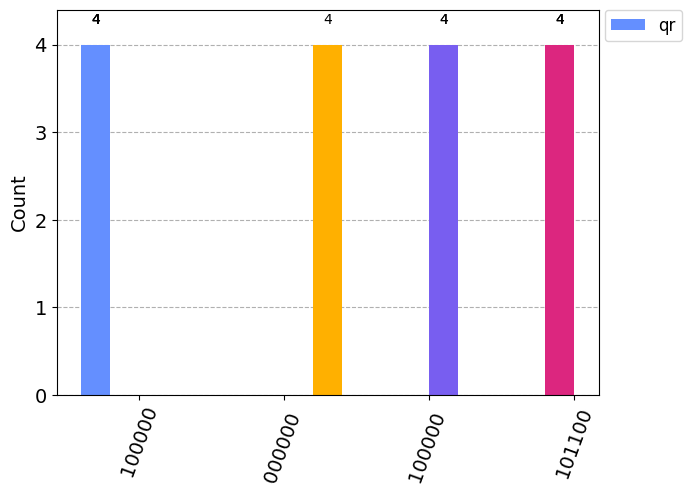

In [ ]:

# Separar las cuentas de los cuatro registros
counts_qr = {key[20:]: counts[key] for key in counts.keys()}
counts_qr1 = {key[14:20]: counts[key] for key in counts.keys()}
counts_qr2 = {key[7:14]: counts[key] for key in counts.keys()}
counts_qr3 = {key[:7]: counts[key] for key in counts.keys()}

# Imprimir las cuentas
print("Counts for qr: ", counts_qr)#azul claro
print("Counts for qr1: ", counts_qr1)#morado
print("Counts for qr2: ", counts_qr2)
print("Counts for qr3: ", counts_qr3)

# Dibujar los histogramas de las cuentas
plot_histogram([counts_qr, counts_qr1, counts_qr2, counts_qr3], legend=['qr', 'qr1', 'qr2', 'qr3'])

In [ ]:
padre_hijo(qc, qr1, qr2, ancilla,hasta+1,6)

5


In [ ]:
qc.draw()

In [ ]:
from qiskit import QuantumCircuit

# Inicialización
qc = QuantumCircuit(3)

# Prueba: Cambia |10⟩ a |11⟩
qc.x(0) # primer qubit a |1⟩
# el segundo qubit está en |0⟩

# Implementación del circuito
qc.cx(0, 1) # Para |10⟩ => |11⟩
qc.x(0)
qc.x(1) # Prepara los qubits para la siguiente operación
qc.ccx(0, 1, 2) # Marca |00⟩ en el ancilla
qc.x(1) # Aplica NOT en q[1] si el ancilla está en |1⟩
qc.x(0)
qc.cx(2, 1)
qc.x(1)
qc.x(2) # Devuelve los qubits y el ancilla a sus estados originales

qc.barrier()

# Restablece el qubit ancilla
qc.ccx(0, 2, 1)
qc.ccx(0, 1, 2)
qc.ccx(0, 2, 1)
qc.reset(2)

print(qc)


     ┌───┐     ┌───┐     ┌───┐           ░                     
q_0: ┤ X ├──■──┤ X ├──■──┤ X ├───────────░───■────■────■───────
     └───┘┌─┴─┐├───┤  │  ├───┤┌───┐┌───┐ ░ ┌─┴─┐  │  ┌─┴─┐     
q_1: ─────┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├─░─┤ X ├──■──┤ X ├─────
          └───┘└───┘┌─┴─┐└───┘└─┬─┘├───┤ ░ └─┬─┘┌─┴─┐└─┬─┘     
q_2: ───────────────┤ X ├───────■──┤ X ├─░───■──┤ X ├──■───|0>─
                    └───┘          └───┘ ░      └───┘          
